In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn import cluster
from shapely.geometry import Point
import regex as re
import random

C:\Users\renss\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [35]:
from bokeh.io import output_notebook, show, curdoc
from bokeh.plotting import figure
from bokeh.layouts import column, row, gridplot
from bokeh.transform import factor_cmap, linear_cmap
from bokeh.palettes import Spectral6, Paired, Turbo256, RdYlBu, Viridis, Spectral, Plasma256, Magma256
from bokeh.models import ColumnDataSource, ColorBar, CustomJS, HoverTool, Select, Range1d, Paragraph, TextInput, Slider, LinearColorMapper, CustomJS, Dropdown, MultiSelect
from bokeh.models.widgets import Slider, Button, TextInput, NumericInput
from bokeh.models.widgets import DataTable, TableColumn, RangeSlider
from bokeh.models import NumeralTickFormatter
import bokeh.models as bm
from bokeh.transform import dodge
from sklearn.preprocessing import StandardScaler
from bokeh.embed import server_document, components

In [3]:
sc = StandardScaler()

In [4]:
output_notebook()

Loading BokehJS ...

In [5]:
lcp_dir = "C:\\Users\\renss\\Documents\\Programming\\LatamRevs\\ShapeFiles"

In [6]:
usa1 = gpd.read_file(lcp_dir + '/USA/usa_adm1.shp')
usa2 = gpd.read_file(lcp_dir + '/USA/usa_adm2.shp')
usa3 = gpd.read_file( 'C:\\Users\\renss\\Documents\\Programming\\Politieke_Analyse\\usa_shape\\cb_2018_us_county_500k.shp')

In [7]:
votes = pd.read_csv("countypres_2000-2020.csv")
income = pd.read_csv("county_complete.csv")

In [8]:
usa2["NAME_1"] = usa2["NAME_1"].str.lower()
votes["state"] = votes["state"].str.lower()
usa2["NAME_2"] = usa2["NAME_2"].str.lower()
votes["county_name"] = votes["county_name"].str.lower()

In [9]:
#drop na county numbers
votes = votes.dropna(subset=["county_fips"])

In [10]:
votes["county_fips"] = votes["county_fips"].astype('int64')

In [11]:
usa3 = usa3[["GEOID", "NAME", "geometry"]]
usa3["GEOID"] = usa3["GEOID"].astype('int64')

In [12]:
#save total figures
totals = votes[["year", "county_fips", "totalvotes"]].drop_duplicates()

In [13]:
mode_total = votes[votes["mode"] == "TOTAL"][['year', 'state', 'state_po', 'county_name', 'county_fips', 'office',
       'candidate', 'party', 'candidatevotes']]
mode_non_total = votes[(votes["mode"] != "TOTAL") & (votes["state"] != "utah")].groupby(['year', 'state', 'state_po', 'county_name', 'county_fips', 'office',
       'candidate', 'party'])['candidatevotes'].sum().reset_index()
#fix salt lake separately because of changed reporting method
salt_lake = votes[(votes["year"] != "2020") & (votes["mode"] != "TOTAL") & (votes["county_fips"] == 49035)].groupby(['year', 'state', 'state_po', 'county_name', 'county_fips', 'office',
       'candidate', 'party'])['candidatevotes'].sum().reset_index()

In [14]:
merged_votes = pd.concat([mode_total, mode_non_total, salt_lake ])

In [15]:
merged_votes = pd.merge(merged_votes, totals, left_on = ["year", "county_fips"] , right_on = ["year", "county_fips"], how = "left")

In [16]:
merged_votes["share_of_votes"] = (merged_votes["candidatevotes"] / merged_votes["totalvotes"]) * 100

<AxesSubplot: >

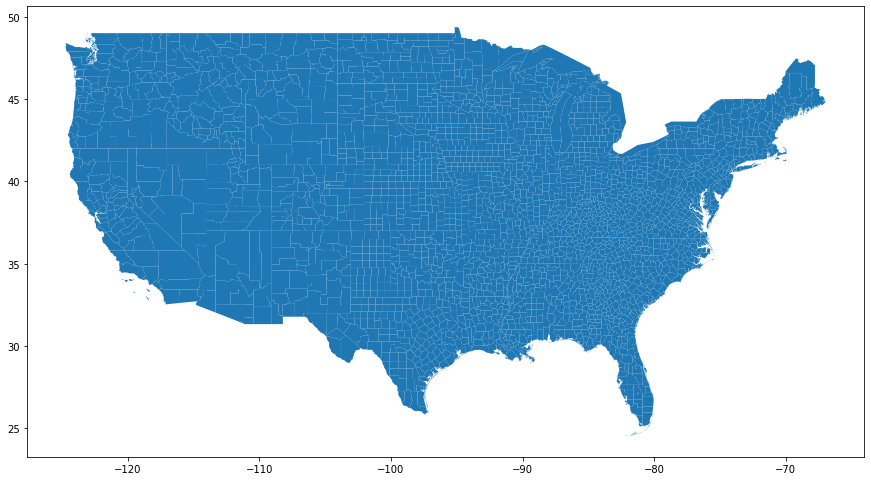

In [17]:
usa2[~usa2.NAME_1.isin(["hawaii", "alaska"])].plot(figsize = (15,15))

In [18]:
share_votes = pd.pivot_table(merged_votes[merged_votes["year"] == 2020], values = [ 'share_of_votes'], index = ["county_fips", "state"], columns = ["candidate"]).fillna(0)

In [19]:
level_one = share_votes.columns.get_level_values(0).astype(str)
level_two = share_votes.columns.get_level_values(1).astype(str)
share_votes.columns = level_one + "_" + level_two
share_votes = share_votes.reset_index()

In [20]:
share_votes.columns = ['county_fips', 'state', 'share_of_votes_TRUMP',
       'share_of_votes_JORGENSEN', 'share_of_votes_BIDEN',
       'share_of_votes_OTHER']

In [21]:
full = pd.merge(usa3, share_votes ,left_on = "GEOID", right_on = "county_fips", how = "left")

<AxesSubplot: >

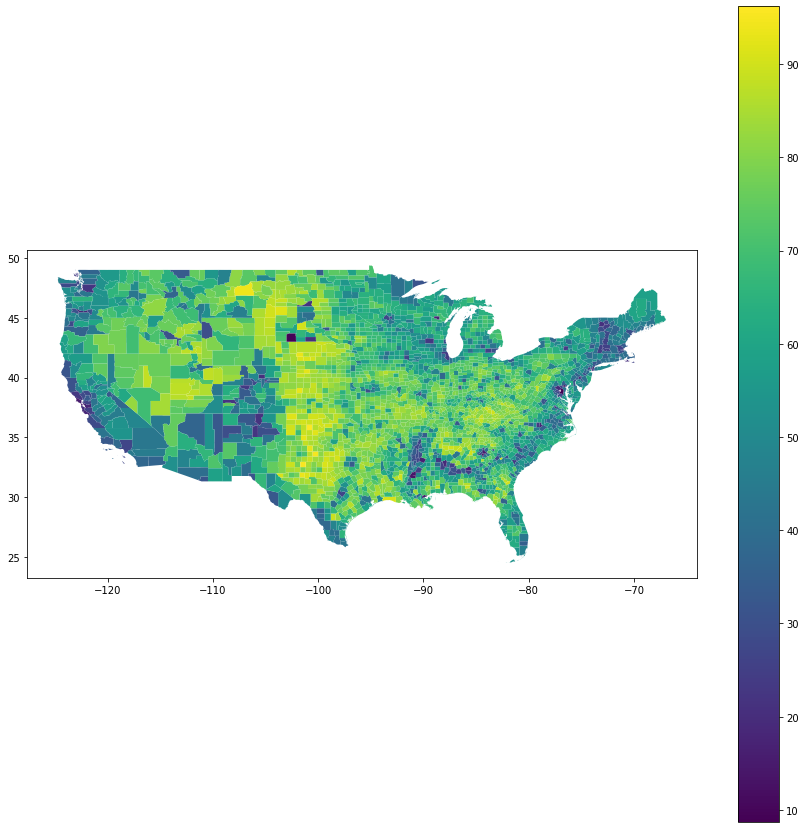

In [22]:
full[~full.state.isin(["hawaii", "alaska"])].plot(figsize = (15,15), column = 'share_of_votes_TRUMP', legend = True)

In [23]:
mix = pd.merge(full,income[["fips", "state", "name",'median_age_2019','bachelors_2019', 'hs_grad_2019' , "mean_household_income_2019", "per_capita_income_2019", "median_household_income_2019"]], left_on = 'county_fips', right_on = 'fips', how = "left")

In [24]:
mix = pd.merge(full, income, left_on = 'county_fips', right_on = 'fips', how = "left")

<AxesSubplot: >

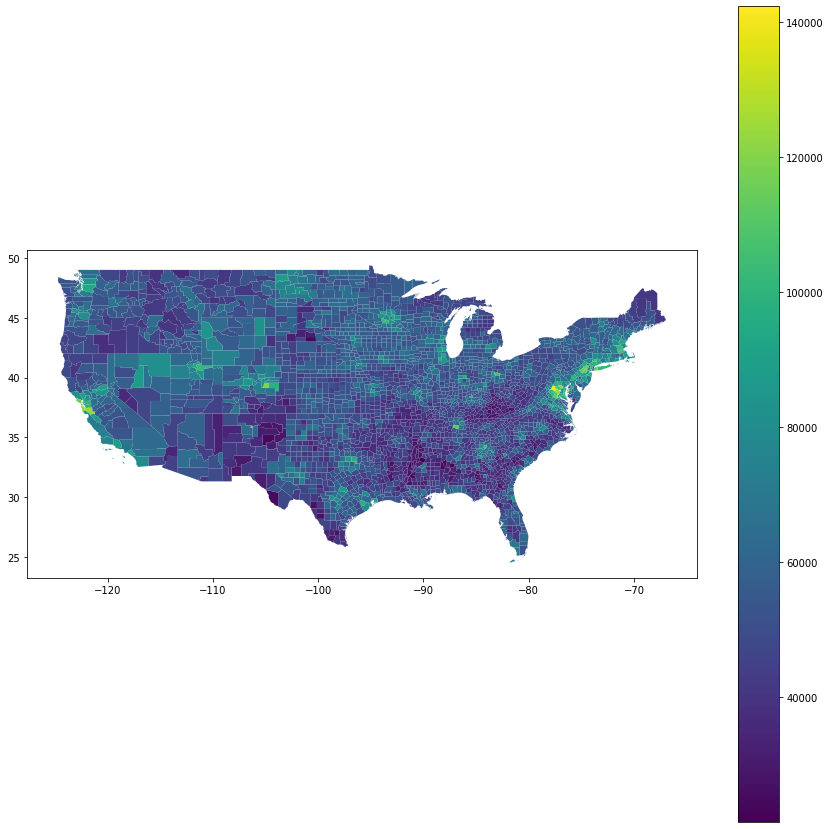

In [25]:
mix[~mix.state_x.isin(["hawaii", "alaska"])].plot(figsize = (15,15), column = "median_household_income_2019", legend = True)

In [26]:
class point():
    
    def __init__(self, x, y):
        self.x_coord = x
        self.y_coord = y
        self.cluster = None
        self.d_2_centroid = None

In [27]:
class cluster_data():
    
    def __init__(self, num_of_points, lower_bound, upper_bound):
        x_coords = np.random.randint(lower_bound, upper_bound, size = num_of_points)
        y_coords = np.random.randint(lower_bound, upper_bound, size = num_of_points)
        points = []
        for i in range(num_of_points):
            points.append(point(x_coords[i], y_coords[i]))
        
        

In [28]:
z = cluster_data(10, 5,50)

In [29]:
z.points

AttributeError: 'cluster_data' object has no attribute 'points'

In [30]:
mix.crs ="4326"
#mix2 = mix[~mix.state_x.isin(["hawaii", "alaska"])][["geometry", "share_of_votes_TRUMP"]]v
mix2 = mix[["geometry", "share_of_votes_TRUMP"]]
geo_src = bm.GeoJSONDataSource(geojson=mix2.to_json())

In [31]:
def set_pallete(low, high):
        #return LinearColorMapper(field_name = dropdown.value, palette = Spectral6, low = low, high = high, nan_color = '#838383')
        return linear_cmap( palette = Spectral6, low = low, high = high, nan_color = '#838383')
    

In [32]:
def modify_doc(doc):

    options=options_to_select = [ "median_household_income_2019", "per_capita_income_2019",
            "mean_household_income_2019", "avg_family_size_2019", "unemployment_rate_2017", "broadband_2017"
            , "bachelors_2019", "white_2019", "black_2019", "native_2019", "asian_2019", "hispanic_2019"
            , "median_age_2019", "hs_grad_2019", "uninsured_2019", 'share_of_votes_TRUMP',
       'share_of_votes_JORGENSEN', 'share_of_votes_BIDEN',
       'share_of_votes_OTHER']

    refresh  = Button(label = "Refresh")
    cluster_slider = Slider(start=2, end=10, value=5, step=1, title="Select the number of clusters", width = 200)
    multi_select = MultiSelect(value=options_to_select , options= options_to_select)
       
    TOOLS = "pan,wheel_zoom,reset,hover,save,box_select"
    
    # Initialize our plot figure
    p = figure(title="A test map", plot_height = 400, width = 600, tools = TOOLS,
               tooltips=[
        ("Name", "@name"),("Cluster", "@clusters")
    ])

    #kmeans = KMeans(n_clusters = 6, init = 'random', random_state = 42)
    kmeans = cluster.KMeans(n_clusters = cluster_slider.value)
    
    # set a color mapper that uses the red-to-green palette, make missing data dark grey
    def set_pallete(low, high):
        return linear_cmap(field_name = "clusters", palette = Spectral6, low = low, high = high, nan_color = '#838383')
    
    mix2_clusters = mix2[["share_of_votes"]].fillna(0).values
    y_kmeans = kmeans.fit_predict(mix2_clusters)
    mix2["clusters"] = y_kmeans
    
    geo_src = bm.GeoJSONDataSource(geojson=mix2[~mix2.state_x.isin(["hawaii", "alaska"])][["geometry","name","clusters"]].to_json())
    
    color_mapper = set_pallete(0,6)

    u = p.patches('xs','ys', source = geo_src,
          color = color_mapper, line_color = 'black', line_width = 0.25, fill_alpha = 1
         )
        
    def means(frame):
        return pd.DataFrame(frame).groupby(by = "clusters").mean()
    
    def cols(m_sel):
        cols = []
        for i in range(len(m_sel)):
            cols.append(TableColumn(field= m_sel[i], title= m_sel[i]))
        return cols
    
    columns = cols(['share_of_votes_BIDEN'])
    mix_means = ColumnDataSource(means(mix2))
    
    p2 = DataTable(source=mix_means, columns = cols(multi_select.value), width=450, height=280)   
    
    def update_data():
        
        kmeans = cluster.KMeans(n_clusters = cluster_slider.value)
        mix2_clusters = mix2[multi_select.value].values
        y_kmeans = cluster.KMeans(n_clusters = cluster_slider.value).fit_predict(mix2_clusters)
        mix2["clusters"] = y_kmeans
           
        mix3 = mix2[~mix2.state_x.isin(["hawaii", "alaska"])][["geometry","name","clusters"]]
        
        
        columns = cols(multi_select.value)
        mix_means.data = means(mix2[multi_select.value + ["clusters"]])

        result = bm.GeoJSONDataSource(geojson=mix3.to_json())
 
        u.glyph.fill_color = color_mapper 
        
        geo_src.geojson = result.geojson
    
    refresh.on_click( update_data)
    
    p.y_range = Range1d(23,50)
    p.x_range = Range1d(-127,-66)
    
    layout = row(column(row(column(refresh, cluster_slider), multi_select), row(p, p2)))
    
    #p.add_layout(color_bar, 'below')
    
    # add the layout to curdoc
    doc.add_root(layout)
    
#show the doc
show(modify_doc)

ERROR:tornado.application:Uncaught exception GET /autoload.js?bokeh-autoload-element=1004&bokeh-absolute-url=http://localhost:59750&resources=none (::1)
HTTPServerRequest(protocol='http', host='localhost:59750', method='GET', uri='/autoload.js?bokeh-autoload-element=1004&bokeh-absolute-url=http://localhost:59750&resources=none', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "C:\Users\renss\anaconda3\lib\site-packages\tornado\web.py", line 1704, in _execute
    result = await result
  File "C:\Users\renss\anaconda3\lib\site-packages\bokeh\server\views\autoload_js_handler.py", line 62, in get
    session = await self.get_session()
  File "C:\Users\renss\anaconda3\lib\site-packages\bokeh\server\views\session_handler.py", line 144, in get_session
    session = await self.application_context.create_session_if_needed(session_id, self.request, token)
  File "C:\Users\renss\anaconda3\lib\site-packages\bokeh\server\contexts.py", line 243, in create_session_if_ne

In [40]:
global mix3, color_mapper, axis_keys
mix3, color_mapper, axis_keys = None, None, None

def modify_doc(doc):

    options_to_select = [ "Median household income 2019", "Per capita income 2019",
            "Mean household income 2019", "Avg family size 2019", "% Unemployment rate 2017", "% Broadband 2017"
            , "% Bachelors 2019", "% White 2019", "% Black 2019", "% Native 2019", "% Asian 2019", "% Hispanic 2019"
            , "Median age 2019", "% High school grad 2019", "% Uninsured 2019", '% of votes for Trump',
       '% of votes for Jorgensen', '% of votes for Biden', '% of votes for Others']
    
    df_keys = [ "median_household_income_2019", "per_capita_income_2019",
            "mean_household_income_2019", "avg_family_size_2019", "unemployment_rate_2017", "broadband_2017"
            , "bachelors_2019", "white_2019", "black_2019", "native_2019", "asian_2019", "hispanic_2019"
            , "median_age_2019", "hs_grad_2019", "uninsured_2019", 'share_of_votes_TRUMP',
       'share_of_votes_JORGENSEN', 'share_of_votes_BIDEN', 'share_of_votes_OTHER']
    
    cluster_options = list(range(1,11))
    
    refresh  = Button(label = "Refresh")
    dropdown = Select(title="X-axis metric", value= '% of votes for Biden', options=options_to_select, width = 200)
    dropdown2 = Select(title="Y-axis metric", value= "Per capita income 2019", options=options_to_select, width = 200)
    
    cluster_slider = Slider(start=2, end=10, value=5, step=1, title="Select the number of clusters", width = 150)
    
    multi_select = MultiSelect(title = "Select categories to cluster on", value=options_to_select , options= options_to_select, width = 200, height = 170)
    cluster_select = MultiSelect(title = "Select visible clusters", value=list(str(i) for i in cluster_options[0:cluster_slider.value]) , options= list(str(i) for i in cluster_options[0:cluster_slider.value]) , width = 200, height = 170)
       
    TOOLS = "pan,wheel_zoom,reset,hover,save,lasso_select,box_select"
    
    clustering_algos = [cluster.KMeans, cluster.Birch, cluster.MeanShift, cluster.SpectralClustering, cluster.AgglomerativeClustering]
    clustering_algos_names = ["KMeans", "Birch", "Mean Shift", "Spectral", "Agglomerative"]
    algo_select = Select(title="Select clustering method", value="KMeans", options=clustering_algos_names, width = 200)
    # Initialize our plot figure
    p = figure(title="U.S. counties clustered by selection.", plot_height = 400, width = 600, tools = TOOLS)

    p2 = figure(title="Scatter plot of U.S. counties", plot_height = 400, width = 375, tools = TOOLS)
    
    def set_cluster_algo(choice, n_clusters):
        method = clustering_algos[clustering_algos_names.index(choice)]
        if choice == "Birch":
            return clustering_algos[clustering_algos_names.index(choice)](n_clusters = n_clusters )
        if choice == "KMeans":
            return clustering_algos[clustering_algos_names.index(choice)](n_clusters = n_clusters, init = 'random')
        if choice == "Mean Shift":
            return clustering_algos[clustering_algos_names.index(choice)](bandwidth=2, cluster_all = False)
        if choice == "Spectral":
            return clustering_algos[clustering_algos_names.index(choice)](n_clusters = n_clusters)
        if choice == "Agglomerative":
            return clustering_algos[clustering_algos_names.index(choice)](n_clusters = n_clusters)
    
    def means(frame):
        return pd.DataFrame(frame).groupby(by = "clusters").mean()
    
    
    # set a color mapper that uses the red-to-green palette, make missing data dark grey
    def set_pallete(low, high):
        #return LinearColorMapper(field_name = dropdown.value, palette = Spectral6, low = low, high = high, nan_color = '#838383')
        return linear_cmap(field_name = "clusters", palette = Plasma256, low = low, high = high, nan_color = '#838383')
    
    def get_technical_keys(category_names):
        return [df_keys[options_to_select.index(i)] for i in category_names]
    
    global axis_keys
    axis_keys = get_technical_keys([dropdown.value, dropdown2.value])

    def add_hover(fig):
        fig.add_tools(HoverTool(tooltips=[("Name", "@name"),("Cluster", "@clusters"), (f"{dropdown.value}", f"@{axis_keys[0]}")
                                   , (f"{dropdown2.value}", f"@{axis_keys[1]}") ]))
    #add tooltips
    add_hover(p)
    add_hover(p2)
    
    cluster_algo = set_cluster_algo(algo_select.value, cluster_slider.value)
    
    update_keys = get_technical_keys([dropdown.value, dropdown2.value])
    
    
    #mix2 = pd.read_csv("final_data.csv").fillna(0)
    mix2 = mix.fillna(0)
    #mix2_clusters = mix[update_keys].values
    y_cluster = cluster_algo.fit_predict(sc.fit_transform(mix2[update_keys].values)) + 1
    mix2["clusters"] = y_cluster
    
    geo_src = bm.GeoJSONDataSource(geojson=mix2[~mix2.state_x.isin(["hawaii", "alaska"])][["geometry","name","clusters"] + update_keys].to_json())
    global mix3
    mix3 = mix2[~mix2.state_x.isin(["hawaii", "alaska"])][["geometry","name","clusters"] + update_keys]
    global color_mapper
    color_mapper = set_pallete(1, cluster_slider.value)
    
    u = p.patches('xs','ys', source = geo_src, #fill_color = dropdown.value,
            color = color_mapper, line_color = 'black', line_width = 0.25, fill_alpha = 1
         )
    
    p2.circle(update_keys[0], update_keys[1], source = geo_src
              , size = 10
              , line_color="black"
              , fill_color=color_mapper
        )    
    
    #replace axis labels and set start rango at 0
    p2.xaxis.axis_label = dropdown.value
    p2.yaxis.axis_label = dropdown2.value
    p2.x_range.start =  0
    p2.y_range.start =  0

    def update_data():
        #re-cluster dataframe based on selected parameters
        cluster_algo = set_cluster_algo(algo_select.value, cluster_slider.value)
        
        update_keys = get_technical_keys(multi_select.value)
        global axis_keys
        axis_keys = get_technical_keys([dropdown.value, dropdown2.value])
        
        mix2_clusters = mix2[update_keys].values
        y_cluster = cluster_algo.fit_predict(sc.fit_transform(mix2[update_keys].values)) + 1
        mix2["clusters"] = y_cluster
    
        #final data to be visualized and turned into JSON
        global mix3
        mix3 = mix2[~mix2.state_x.isin(["hawaii", "alaska"])][["geometry","name","clusters"] + list(set(update_keys + axis_keys))]       
        result = bm.GeoJSONDataSource(geojson=mix3.to_json())
        
        #adjust color mapper and update glyph fill colors
        global color_mapper
        color_mapper = set_pallete(1, cluster_slider.value)
        u.glyph.fill_color = color_mapper
        
        p2.circle(axis_keys[0], axis_keys[1], source = geo_src
              , size = 10
              , line_color="black"
              , fill_color=color_mapper
        )   
 
        #replace Geo JSON data
        geo_src.geojson = result.geojson
        
        #replace axis labels
        p2.xaxis.axis_label = dropdown.value
        p2.yaxis.axis_label = dropdown2.value
        p2.x_range.end, p2.y_range.end =  mix3[axis_keys[0]].max() *1.05, mix3[axis_keys[1]].max() *1.05
        p2.xaxis[0].formatter = NumeralTickFormatter(format="0.")
        p2.yaxis[0].formatter = NumeralTickFormatter(format="0.")
        
        #update number of clusters in cluster selector
        cluster_select.value = list(str(i) for i in cluster_options[0:cluster_slider.value])
        cluster_select.options = list(str(i) for i in cluster_options[0:cluster_slider.value])
        
        add_hover(p)
        add_hover(p2)
        
    def filter_cluster(attr, old, new):
        mix_fl = mix3[mix3.clusters.isin([int(i) for i in cluster_select.value])]
        result = bm.GeoJSONDataSource(geojson=mix_fl.to_json())
        #replace Geo JSON data
        geo_src.geojson = result.geojson
        
        #update scatter plot ranges
        p2.x_range.end, p2.y_range.end =  np.round(mix3[axis_keys[0]].max() *1.05,2), np.round(mix3[axis_keys[1]].max() *1.05,2)
        #p2.xaxis[0].formatter = NumeralTickFormatter(format="0.")
        #p2.yaxis[0].formatter = NumeralTickFormatter(format="0.")
            
    #refesh data with on click action
    refresh.on_click( update_data)
    cluster_select.on_change("value", filter_cluster)
      
    p.y_range = Range1d(23,50)
    p.x_range = Range1d(-127,-66)
    
    layout = row(column(row(column(refresh, cluster_slider), column(dropdown, dropdown2, algo_select), column(cluster_select), multi_select), row(p, p2)))

    # add the layout to curdoc
    doc.add_root(layout)
    
#show the doc
show(modify_doc)

In [ ]:
global mix3, color_mapper, axis_keys
mix3, color_mapper, axis_keys = None, None, None

def modify_doc(doc):

    options_to_select = [ "Median household income 2019", "Per capita income 2019",
            "Mean household income 2019", "Avg family size 2019", "% Unemployment rate 2017", "% Broadband 2017"
            , "% Bachelors 2019", "% White 2019", "% Black 2019", "% Native 2019", "% Asian 2019", "% Hispanic 2019"
            , "Median age 2019", "% High school grad 2019", "% Uninsured 2019", '% of votes for Trump',
       '% of votes for Jorgensen', '% of votes for Biden', '% of votes for Others']
    
    df_keys = [ "median_household_income_2019", "per_capita_income_2019",
            "mean_household_income_2019", "avg_family_size_2019", "unemployment_rate_2017", "broadband_2017"
            , "bachelors_2019", "white_2019", "black_2019", "native_2019", "asian_2019", "hispanic_2019"
            , "median_age_2019", "hs_grad_2019", "uninsured_2019", 'share_of_votes_TRUMP',
       'share_of_votes_JORGENSEN', 'share_of_votes_BIDEN', 'share_of_votes_OTHER']
    
    cluster_options = list(range(1,11))
    
    refresh  = Button(label = "Refresh")
    dropdown = Select(title="X-axis metric", value= '% of votes for Biden', options=options_to_select, width = 200)
    dropdown2 = Select(title="Y-axis metric", value= "Per capita income 2019", options=options_to_select, width = 200)
    
    cluster_slider = Slider(start=2, end=10, value=5, step=1, title="Select the number of clusters", width = 150)
    
    multi_select = MultiSelect(title = "Select categories to cluster on", value=options_to_select , options= options_to_select, width = 200, height = 170)
    cluster_select = MultiSelect(title = "Select visible clusters", value=list(str(i) for i in cluster_options[0:cluster_slider.value]) , options= list(str(i) for i in cluster_options[0:cluster_slider.value]) , width = 200, height = 170)
       
    TOOLS = "pan,wheel_zoom,reset,hover,save,lasso_select,box_select"
    
    clustering_algos = [cluster.KMeans, cluster.Birch, cluster.MeanShift, cluster.SpectralClustering, cluster.AgglomerativeClustering]
    clustering_algos_names = ["KMeans", "Birch", "Mean Shift", "Spectral", "Agglomerative"]
    algo_select = Select(title="Select clustering method", value="KMeans", options=clustering_algos_names, width = 200)
    # Initialize our plot figure
    p = figure(title="U.S. counties clustered by selection.", plot_height = 400, width = 600, tools = TOOLS)

    p2 = figure(title="Scatter plot of U.S. counties", plot_height = 400, width = 375, tools = TOOLS)
    
    def set_cluster_algo(choice, n_clusters):
        method = clustering_algos[clustering_algos_names.index(choice)]
        if choice == "Birch":
            return clustering_algos[clustering_algos_names.index(choice)](n_clusters = n_clusters )
        if choice == "KMeans":
            return clustering_algos[clustering_algos_names.index(choice)](n_clusters = n_clusters, init = 'random')
        if choice == "Mean Shift":
            return clustering_algos[clustering_algos_names.index(choice)](bandwidth=2, cluster_all = False)
        if choice == "Spectral":
            return clustering_algos[clustering_algos_names.index(choice)](n_clusters = n_clusters)
        if choice == "Agglomerative":
            return clustering_algos[clustering_algos_names.index(choice)](n_clusters = n_clusters)
    
    def means(frame):
        return pd.DataFrame(frame).groupby(by = "clusters").mean()
    
    
    # set a color mapper that uses the red-to-green palette, make missing data dark grey
    def set_pallete(low, high):
        #return LinearColorMapper(field_name = dropdown.value, palette = Spectral6, low = low, high = high, nan_color = '#838383')
        return linear_cmap(field_name = "clusters", palette = Plasma256, low = low, high = high, nan_color = '#838383')
    
    def get_technical_keys(category_names):
        return [df_keys[options_to_select.index(i)] for i in category_names]
    
    global axis_keys
    axis_keys = get_technical_keys([dropdown.value, dropdown2.value])

    def add_hover(fig):
        fig.add_tools(HoverTool(tooltips=[("Name", "@name"),("Cluster", "@clusters"), (f"{dropdown.value}", f"@{axis_keys[0]}")
                                   , (f"{dropdown2.value}", f"@{axis_keys[1]}") ]))
    #add tooltips
    add_hover(p)
    add_hover(p2)
    
    cluster_algo = set_cluster_algo(algo_select.value, cluster_slider.value)
    
    update_keys = get_technical_keys([dropdown.value, dropdown2.value])
    
    mix2 = mix.fillna(0)
    #mix2_clusters = mix[update_keys].values
    y_cluster = cluster_algo.fit_predict(sc.fit_transform(mix2[update_keys].values)) + 1
    mix2["clusters"] = y_cluster
    
    geo_src = bm.GeoJSONDataSource(geojson=mix2[["geometry","name","clusters"] + update_keys].to_json())
    global mix3
    mix3 = mix2[["geometry","name","clusters"] + update_keys]
    global color_mapper
    color_mapper = set_pallete(1, cluster_slider.value)
    
    u = p.patches('xs','ys', source = geo_src, #fill_color = dropdown.value,
            color = color_mapper, line_color = 'black', line_width = 0.25, fill_alpha = 1
         )
    
    p2.circle(update_keys[0], update_keys[1], source = geo_src
              , size = 10
              , line_color="black"
              , fill_color=color_mapper
        )    
    
    #replace axis labels and set start rango at 0
    p2.xaxis.axis_label = dropdown.value
    p2.yaxis.axis_label = dropdown2.value
    p2.x_range.start =  0
    p2.y_range.start =  0

    def update_data():
        #re-cluster dataframe based on selected parameters
        cluster_algo = set_cluster_algo(algo_select.value, cluster_slider.value)
        
        update_keys = get_technical_keys(multi_select.value)
        global axis_keys
        axis_keys = get_technical_keys([dropdown.value, dropdown2.value])
        
        mix2_clusters = mix2[update_keys].values
        y_cluster = cluster_algo.fit_predict(sc.fit_transform(mix2[update_keys].values)) + 1
        mix2["clusters"] = y_cluster
    
        #final data to be visualized and turned into JSON
        global mix3
        mix3 = mix2[["geometry","name","clusters"] + list(set(update_keys + axis_keys))]       
        result = bm.GeoJSONDataSource(geojson=mix3.to_json())
        
        #adjust color mapper and update glyph fill colors
        global color_mapper
        color_mapper = set_pallete(1, cluster_slider.value)
        u.glyph.fill_color = color_mapper
        
        p2.circle(axis_keys[0], axis_keys[1], source = geo_src
              , size = 10
              , line_color="black"
              , fill_color=color_mapper
        )   
 
        #replace Geo JSON data
        geo_src.geojson = result.geojson
        
        #replace axis labels
        p2.xaxis.axis_label = dropdown.value
        p2.yaxis.axis_label = dropdown2.value
        p2.x_range.end, p2.y_range.end =  mix3[axis_keys[0]].max() *1.05, mix3[axis_keys[1]].max() *1.05
        p2.xaxis[0].formatter = NumeralTickFormatter(format="0.")
        p2.yaxis[0].formatter = NumeralTickFormatter(format="0.")
        
        #update number of clusters in cluster selector
        cluster_select.value = list(str(i) for i in cluster_options[0:cluster_slider.value])
        cluster_select.options = list(str(i) for i in cluster_options[0:cluster_slider.value])
        
        add_hover(p)
        add_hover(p2)
        
    def filter_cluster(attr, old, new):
        mix_fl = mix3[mix3.clusters.isin([int(i) for i in cluster_select.value])]
        result = bm.GeoJSONDataSource(geojson=mix_fl.to_json())
        #replace Geo JSON data
        geo_src.geojson = result.geojson
        
        #update scatter plot ranges
        p2.x_range.end, p2.y_range.end =  np.round(mix3[axis_keys[0]].max() *1.05,2), np.round(mix3[axis_keys[1]].max() *1.05,2)
        #p2.xaxis[0].formatter = NumeralTickFormatter(format="0.")
        #p2.yaxis[0].formatter = NumeralTickFormatter(format="0.")
            
    #refesh data with on click action
    refresh.on_click( update_data)
    cluster_select.on_change("value", filter_cluster)
      
    p.y_range = Range1d(23,50)
    p.x_range = Range1d(-127,-66)
    
    layout = row(column(row(column(refresh, cluster_slider), column(dropdown, dropdown2, algo_select), column(cluster_select), multi_select), row(p, p2)))

    # add the layout to curdoc
    doc.add_root(layout)
    
#show the doc
show(modify_doc)

In [ ]:
list(str(mix[mix.state_x == "hawaii"].iloc[1]["geometry"]).split(" "))

In [ ]:
str(mix[mix.state_x == "hawaii"].iloc[0]["geometry"][0])

In [ ]:
def move_polygon(row):
    if "MULTIPOLYGON" in str(row["geometry"]):
        pass
    else:
        coords = pol_to_np(str(row["geometry"]))
    return coords

In [ ]:
def pol_to_np(polygon):
    m = re.search("\(.*", str(polygon))
    t = np.array(m[0].replace("(", "").replace(")", "").replace(",", "").split(" ")).astype(float)
    return t

In [ ]:
test = pol_to_np(mix[mix.state_x == "hawaii"].iloc[1]["geometry"]) + 50

In [ ]:
test

In [ ]:
mix[mix.state_x == "hawaii"].iloc[1]["geometry"] = test

In [ ]:
mix[mix.state_x == "hawaii"].iloc[1]["geometry"].coords.xy

In [ ]:
str(mix[mix.state_x == "hawaii"].iloc[1]["geometry"])

In [ ]:
import regex as re

In [ ]:
z = re.search("\(.*", str(mix[mix.state_x == "hawaii"].iloc[1]["geometry"]))

In [ ]:
z[0]

In [ ]:
import ast

In [ ]:
ast.literal_eval( z[0].replace("(", "").replace(")", ""))

In [ ]:
t = np.array(z[0].replace("(", "").replace(")", "").replace(",", "").split(" "))

In [ ]:
help(t)

In [ ]:
t.astype(float) + 2

In [ ]:
global mix3, color_mapper, axis_keys
mix3, color_mapper, axis_keys = None, None, None

def modify_doc(doc):

    options_to_select = [ "Median household income 2019", "Per capita income 2019",
            "Mean household income 2019", "Avg family size 2019", "% Unemployment rate 2017", "% Broadband 2017"
            , "% Bachelors 2019", "% White 2019", "% Black 2019", "% Native 2019", "% Asian 2019", "% Hispanic 2019"
            , "Median age 2019", "% High school grad 2019", "% Uninsured 2019", '% of votes for Trump',
       '% of votes for Jorgensen', '% of votes for Biden', '% of votes for Others']
    
    df_keys = [ "median_household_income_2019", "per_capita_income_2019",
            "mean_household_income_2019", "avg_family_size_2019", "unemployment_rate_2017", "broadband_2017"
            , "bachelors_2019", "white_2019", "black_2019", "native_2019", "asian_2019", "hispanic_2019"
            , "median_age_2019", "hs_grad_2019", "uninsured_2019", 'share_of_votes_TRUMP',
       'share_of_votes_JORGENSEN', 'share_of_votes_BIDEN', 'share_of_votes_OTHER']
    
    cluster_options = list(range(1,11))
    
    refresh  = Button(label = "Refresh")
    dropdown = Select(title="X-axis metric", value= '% of votes for Biden', options=options_to_select, width = 200)
    dropdown2 = Select(title="Y-axis metric", value= "Per capita income 2019", options=options_to_select, width = 200)
    
    cluster_slider = Slider(start=2, end=10, value=5, step=1, title="Select the number of clusters", width = 150)
    
    multi_select = MultiSelect(title = "Select categories to cluster on", value=options_to_select , options= options_to_select, width = 200, height = 170)
    cluster_select = MultiSelect(title = "Select visible clusters", value=list(str(i) for i in cluster_options[0:cluster_slider.value]) , options= list(str(i) for i in cluster_options[0:cluster_slider.value]) , width = 200, height = 170)
       
    TOOLS = "pan,wheel_zoom,reset,hover,save,lasso_select,box_select"
    
    clustering_algos = [cluster.KMeans, cluster.Birch, cluster.MeanShift, cluster.SpectralClustering, cluster.AgglomerativeClustering]
    clustering_algos_names = ["KMeans", "Birch", "Mean Shift", "Spectral", "Agglomerative"]
    algo_select = Select(title="Select clustering method", value="KMeans", options=clustering_algos_names, width = 200)
    # Initialize our plot figure
    p = figure(title="U.S. counties clustered by selection.", plot_height = 400, width = 600, tools = TOOLS)

    p2 = figure(title="Scatter plot of U.S. counties", plot_height = 400, width = 375, tools = TOOLS)
    
    def set_cluster_algo(choice, n_clusters):
        method = clustering_algos[clustering_algos_names.index(choice)]
        if choice == "Birch":
            return clustering_algos[clustering_algos_names.index(choice)](n_clusters = n_clusters )
        if choice == "KMeans":
            return clustering_algos[clustering_algos_names.index(choice)](n_clusters = n_clusters, init = 'random')
        if choice == "Mean Shift":
            return clustering_algos[clustering_algos_names.index(choice)](bandwidth=2, cluster_all = False)
        if choice == "Spectral":
            return clustering_algos[clustering_algos_names.index(choice)](n_clusters = n_clusters)
        if choice == "Agglomerative":
            return clustering_algos[clustering_algos_names.index(choice)](n_clusters = n_clusters)
    
    def means(frame):
        return pd.DataFrame(frame).groupby(by = "clusters").mean()
    
    
    # set a color mapper that uses the red-to-green palette, make missing data dark grey
    def set_pallete(low, high):
        #return LinearColorMapper(field_name = dropdown.value, palette = Spectral6, low = low, high = high, nan_color = '#838383')
        return linear_cmap(field_name = "clusters", palette = Plasma256, low = low, high = high, nan_color = '#838383')
    
    def get_technical_keys(category_names):
        return [df_keys[options_to_select.index(i)] for i in category_names]
    
    global axis_keys
    axis_keys = get_technical_keys([dropdown.value, dropdown2.value])

    def add_hover(fig):
        fig.add_tools(HoverTool(tooltips=[("Name", "@name"),("Cluster", "@clusters"), (f"{dropdown.value}", f"@{axis_keys[0]}")
                                   , (f"{dropdown2.value}", f"@{axis_keys[1]}") ]))
    #add tooltips
    add_hover(p)
    add_hover(p2)
    
    cluster_algo = set_cluster_algo(algo_select.value, cluster_slider.value)
    
    update_keys = get_technical_keys([dropdown.value, dropdown2.value])
    
    mix2 = mix.fillna(0)
    #mix2_clusters = mix[update_keys].values
    y_cluster = cluster_algo.fit_predict(sc.fit_transform(mix2[update_keys].values)) + 1
    mix2["clusters"] = y_cluster
    
    geo_src = bm.GeoJSONDataSource(geojson=mix2[~mix2.state_x.isin(["hawaii", "alaska"])][["geometry","name","clusters"] + update_keys].to_json())
    global mix3
    mix3 = mix2[~mix2.state_x.isin(["hawaii", "alaska"])][["geometry","name","clusters"] + update_keys]
    global color_mapper
    color_mapper = set_pallete(1, cluster_slider.value)
    
    u = p.patches('xs','ys', source = geo_src, #fill_color = dropdown.value,
            color = color_mapper, line_color = 'black', line_width = 0.25, fill_alpha = 1
         )
    
    p2.circle(update_keys[0], update_keys[1], source = geo_src
              , size = 10
              , line_color="black"
              , fill_color=color_mapper
        )    
    
    #replace axis labels and set start rango at 0
    p2.xaxis.axis_label = dropdown.value
    p2.yaxis.axis_label = dropdown2.value
    p2.x_range.start =  0
    p2.y_range.start =  0

    def update_data():
        #re-cluster dataframe based on selected parameters
        cluster_algo = set_cluster_algo(algo_select.value, cluster_slider.value)
        
        update_keys = get_technical_keys(multi_select.value)
        global axis_keys
        axis_keys = get_technical_keys([dropdown.value, dropdown2.value])
        
        mix2_clusters = mix2[update_keys].values
        y_cluster = cluster_algo.fit_predict(sc.fit_transform(mix2[update_keys].values)) + 1
        mix2["clusters"] = y_cluster
    
        #final data to be visualized and turned into JSON
        global mix3
        mix3 = mix2[~mix2.state_x.isin(["hawaii", "alaska"])][["geometry","name","clusters"] + list(set(update_keys + axis_keys))]       
        result = bm.GeoJSONDataSource(geojson=mix3.to_json())
        
        #adjust color mapper and update glyph fill colors
        global color_mapper
        color_mapper = set_pallete(1, cluster_slider.value)
        u.glyph.fill_color = color_mapper
        
        p2.circle(axis_keys[0], axis_keys[1], source = geo_src
              , size = 10
              , line_color="black"
              , fill_color=color_mapper
        )   
 
        #replace Geo JSON data
        geo_src.geojson = result.geojson
        
        #replace axis labels
        p2.xaxis.axis_label = dropdown.value
        p2.yaxis.axis_label = dropdown2.value
        p2.x_range.end, p2.y_range.end =  mix3[axis_keys[0]].max() *1.05, mix3[axis_keys[1]].max() *1.05
        p2.xaxis[0].formatter = NumeralTickFormatter(format="0.")
        p2.yaxis[0].formatter = NumeralTickFormatter(format="0.")
        
        #update number of clusters in cluster selector
        cluster_select.value = list(str(i) for i in cluster_options[0:cluster_slider.value])
        cluster_select.options = list(str(i) for i in cluster_options[0:cluster_slider.value])
        
        add_hover(p)
        add_hover(p2)
        
    def filter_cluster(attr, old, new):
        mix_fl = mix3[mix3.clusters.isin([int(i) for i in cluster_select.value])]
        result = bm.GeoJSONDataSource(geojson=mix_fl.to_json())
        #replace Geo JSON data
        geo_src.geojson = result.geojson
        
        #update scatter plot ranges
        p2.x_range.end, p2.y_range.end =  np.round(mix3[axis_keys[0]].max() *1.05,2), np.round(mix3[axis_keys[1]].max() *1.05,2)
        #p2.xaxis[0].formatter = NumeralTickFormatter(format="0.")
        #p2.yaxis[0].formatter = NumeralTickFormatter(format="0.")
            
    #refesh data with on click action
    refresh.on_click( update_data)
    cluster_select.on_change("value", filter_cluster)
      
    p.y_range = Range1d(23,50)
    p.x_range = Range1d(-127,-66)
    
    layout = row(column(row(column(refresh, cluster_slider), column(dropdown, dropdown2, algo_select), column(cluster_select), multi_select), row(p, p2)))

    # add the layout to curdoc
    doc.add_root(layout)
    
#show the doc
show(modify_doc)

In [34]:
script,div = bokeh.create_figure_and_get_components(modify_doc)

NameError: name 'bokeh' is not defined